#### 데이터 소개
예를 들어, 아스피린의 화학구조는 탄소 원자 9개, 수소 원자 8개, 산소 원자 4개가 연결되어 있다. 이로부터 분자의 무게, 전하, 표면적 등의 양적 데이터를 알아낼 수 있다. 우리의 목적은 이미 알려진 이러한 특성들로부터 특정 화합물의 용해도(solubility)를 추정하는 것이다. 용해도는 약을 제조할 때 중요한 성질 중 하나다. <br><br>
우리는 1267개의 화합물에 대한 총 228개의 특성 정보를 알고 있다. 각 특성 중에는 이진수와 연속형 자료가 섞여있다.<br><br>
208개의 특성은 0 또는 1의 값을 갖는다. 특정 성질이 있는가 없는가를 나타낸다.<br>
16개의 특성은 자연수 값을 갖는다. 특정 원소의 갯수를 나타내는 등의 정보를 나타낸다.<br>
4개의 특성은 연속적인 값을 갖는다. 분자의 무게나 표면적 등의 정보가 이에 속한다.

## 전처리

#### 테스트 셋 분리하기

1267개의 관측 자료의 1/3(316개)을 임의 추출하여 테스트 셋으로 사용한다. 나머지(951개)가 트레이닝 셋으로 이용된다. (우리는 이미 분리되어 있는 데이터를 사용한다.) <br>
트레이닝 셋은 통해 모델의 성능을 추정하는 데 사용한다. 테스트 셋은 최종적으로 모델을 평가하는 데 사용한다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

# train set
solTrainX = pd.read_csv("C:\\Users\\renz\\프로젝트\\data\\solTrainX.csv", engine='python').drop("Unnamed: 0", axis=1)
solTrainY = pd.read_csv("C:\\Users\\renz\\프로젝트\\data\\solTrainY.csv", engine='python').drop("Unnamed: 0", axis=1)
# test set
solTestX = pd.read_csv("C:\\Users\\renz\\프로젝트\\data\\solTestX.csv", engine='python').drop("Unnamed: 0", axis=1)
solTestY = pd.read_csv("C:\\Users\\renz\\프로젝트\\data\\solTestY.csv", engine='python').drop("Unnamed: 0", axis=1)

In [2]:
a = pd.DataFrame(np.array([[1,2,3],[1,2,3]]))
a['solubility'] = [0,1]
a

,0,1,2,solubility
0,1,2,3,0
1,1,2,3,1


#### skewness 제거하기

이진수를 갖는 208개의 특성은 전처리할 만한 게 거의 없다. 반면 연속형 특성은 오른쪽 꼬리가 길다. 

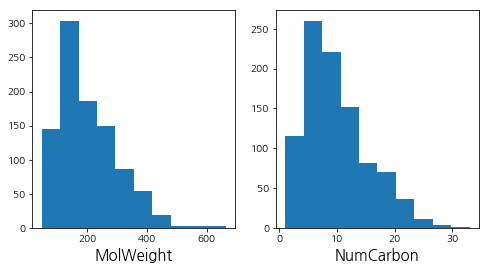

In [3]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(solTrainX['MolWeight'])
plt.xlabel('MolWeight', fontsize=15)

plt.subplot(1,2,2)
plt.hist(solTrainX['NumCarbon'])
plt.xlabel("NumCarbon", fontsize=15)
plt.show()

Box–Cox transformation을 통해 오른쪽 꼬리를 수정한 데이터가 아래 데이터다.

In [4]:
solTrainXtrans = pd.read_csv("C:\\Users\\renz\\프로젝트\\data\\solTrainXtrans.csv", engine='python').drop("Unnamed: 0", axis=1)
solTestXtrans = pd.read_csv("C:\\Users\\renz\\프로젝트\\data\\solTestXtrans.csv", engine='python').drop("Unnamed: 0", axis=1)

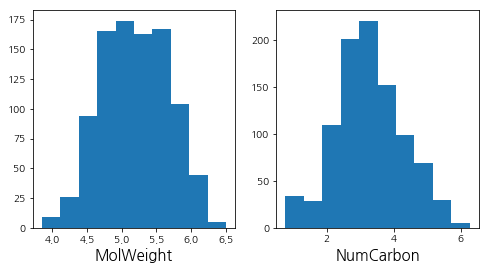

In [5]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(solTrainXtrans['MolWeight'])
plt.xlabel('MolWeight', fontsize=15)
plt.subplot(1,2,2)
plt.hist(solTrainXtrans['NumCarbon'])
plt.xlabel("NumCarbon", fontsize=15)
plt.show()

#### 샘플이 순서대로 들어있을 수도 있으므로, 샘플을 무작위로 섞어주자

In [6]:
# 트레이닝 데이터를 섞어준다.
np.random.seed(42)
shuffle_index1 = np.random.permutation(951)
X_train, y_train = solTrainXtrans.iloc[shuffle_index1], solTrainY.iloc[shuffle_index1]
X_train_skewed = solTrainX.iloc[shuffle_index1]

shuffle_index2 = np.random.permutation(316)
X_test, y_test = solTestXtrans.iloc[shuffle_index2], solTestY.iloc[shuffle_index2]
X_test_skewed = solTestX.iloc[shuffle_index2]


##### 샘플 별 성능 비교

In [7]:
# skewness 조정을 한 샘플과 그렇지 않은 샘플 간 성능 비교.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
box = LinReg.predict(X_test)

LinReg.fit(X_train_skewed, y_train)
skewed = LinReg.predict(X_test_skewed)

print("조정 전 샘플의 RMSE:", np.sqrt(mean_squared_error(skewed, y_test)))
print("조정 후 샘플의 RMSE:", np.sqrt(mean_squared_error(box, y_test)))

조정 전 샘플의 RMSE: 0.7968960931895529
조정 후 샘플의 RMSE: 0.7455801896508939


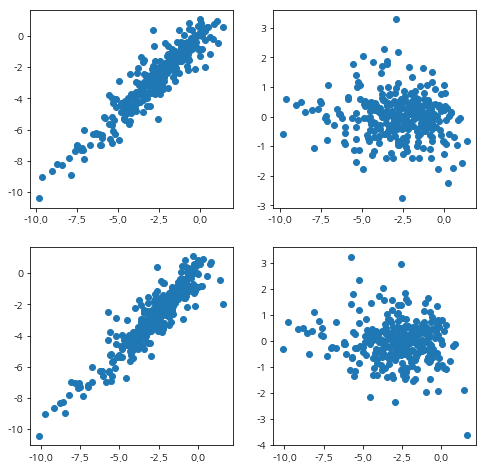

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(box, y_test)
plt.subplot(2, 2, 2)
plt.scatter(box, y_test-box)
plt.subplot(2, 2, 3)
plt.scatter(skewed, y_test)
plt.subplot(2, 2, 4)
plt.scatter(skewed, y_test-skewed)
plt.show()

## Linear Regression

#### 상관계수 파악하기

단순선형회귀에서는 상관계수가 높은 특징 변수를 우선 제거한 다음에 회귀분석을 할 것이다. 여기서는 상관계수가 0.9를 넘는 특성을 제거 대상이다. <br>
예를 들어 특성1과 특성2 사이의 상관계수가 0.9를 넘는다 하자. 그러면 특성1과 특성2 중에서도 다른 특성들 간의 상관계수가 높은 특성을 제거한다. 

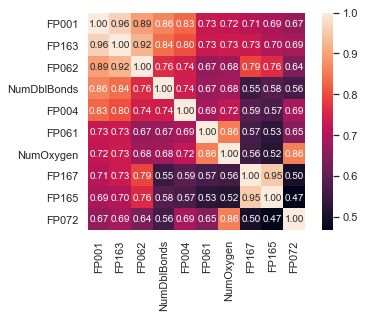

In [9]:
correlations = X_train.corr()

import seaborn as sns

k = 10 # 변수 10개만 사용
cols = correlations.nlargest(k, 'FP001')['FP001'].index
cm = np.corrcoef(solTrainXtrans[cols].values.T)
sns.set(font_scale = 1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [8]:
corr_dataframe = solTrainXtrans.corr()

def remove_high_corr(corr_dataframe, thresh = 0.9):

    abs_corr = np.abs(corr_dataframe).as_matrix() 
    col_names = list(corr_dataframe.columns)
    

    np.fill_diagonal(abs_corr, 0)
    
    while np.max(abs_corr) >= thresh:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape) 

        rdx = which_to_remove(i, j, abs_corr)

        col_names.pop(rdx)
        abs_corr = np.delete(abs_corr, rdx, 0)
        abs_corr = np.delete(abs_corr, rdx, 1)
        
    return col_names

def which_to_remove(i, j, abs_corr):

    i_absmean = np.mean(abs_corr[i, np.where(abs_corr[i,:] == 0)])
    j_absmean = np.mean(abs_corr[j, np.where(abs_corr[j,:] == 0)])
    
    return i if i_absmean > j_absmean else j


col_remained = remove_high_corr(corr_dataframe)
solTrainXtrans_filtered = solTrainXtrans[col_remained]
solTestXtrans_filtered = solTestXtrans[col_remained]

C:\Users\renz\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


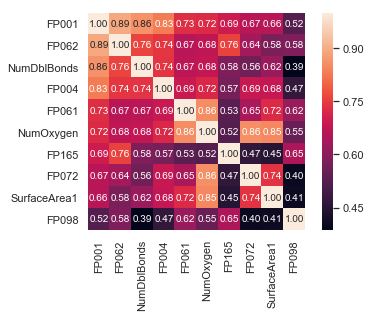

In [9]:
correlations = solTrainXtrans_filtered.corr()

import seaborn as sns

k = 10 
cols = correlations.nlargest(k, 'FP001')['FP001'].index
cm = np.corrcoef(solTrainXtrans_filtered[cols].values.T)
sns.set(font_scale = 1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# 상관계수가 0.9 이상인 특징 변수 삭제

32개의 특성을 제거한 데이터를 X_train_filtered, X_test_filtered에 담았다. 이것도 랜덤으로 섞어주자.

In [10]:
np.random.seed(42)
shuffle_index = np.random.permutation(951)
X_train_filtered = solTrainXtrans_filtered.iloc[shuffle_index]

shuffle_index = np.random.permutation(316)
X_test_filtered = solTestXtrans_filtered.iloc[shuffle_index]

#### 선형회귀를 이용한 추정

트레이닝 셋을 10개의 그룹으로 나누어, 9개의 그룹로 트레이닝한 것을 가지고 나머지 한 개 그룹의 값을 추정한다. (10-fold validation) 

In [11]:
from  sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

def lin_pred(x_fit, y, x_target):
    LinReg = LinearRegression()
    LinReg.fit(x_fit, y)
    return LinReg.predict(x_target)

def lin_val_rmse(x, y, cv=10):
    LinReg = LinearRegression()
    mse = -cross_val_score(LinReg, x, y, cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def lin_val_r2(x, y, cv=10):
    LinReg = LinearRegression()
    r2 = cross_val_score(LinReg, x, y, cv = cv, scoring='r2')
    return r2.mean()

In [13]:
compare_models = pd.DataFrame(columns=('RMSE_val', "R2_val", "RMSE_test", "R2_test"),
                             index=('Linear Reg.', 'Huber Reg.', 'PCA Reg.', 'PLS Reg.', 'ridge',
                                   'Multi Layer Perceptron', 'KNN', 'SVM',
                                   'Tree', 'Bagged Tree', 'Random Forest', "GBM"))

In [14]:
# RMSE, R2 구하기

compare_models['RMSE_val']['Linear Reg.'] = lin_val_rmse(X_train_filtered, y_train)
compare_models['R2_val']['Linear Reg.'] = lin_val_r2(X_train_filtered, y_train)

print("RMSE_val:", lin_val_rmse(X_train_filtered, y_train))
print("R2_val:", lin_val_r2(X_train_filtered, y_train))

RMSE_val: 0.7087850380165187
R2_val: 0.8743046322278405


이를 테스트 셋에도 적용해보자.

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lin_pred_test = lin_pred(X_train_filtered, y_train, X_test_filtered)

compare_models['RMSE_test']['Linear Reg.'] = np.sqrt(mean_squared_error(y_test, lin_pred_test))
compare_models['R2_test']['Linear Reg.'] = r2_score(y_test, lin_pred_test)

print("RMSE_test:", np.sqrt(mean_squared_error(y_test, lin_pred_test)))
print("R2_test:", r2_score(y_test, lin_pred_test))

# 특징변수 선별 전보다 예측력이 좋아졌음을 확인할 수 있다.

RMSE_test: 0.7429178357036604
R2_test: 0.8718349264734622


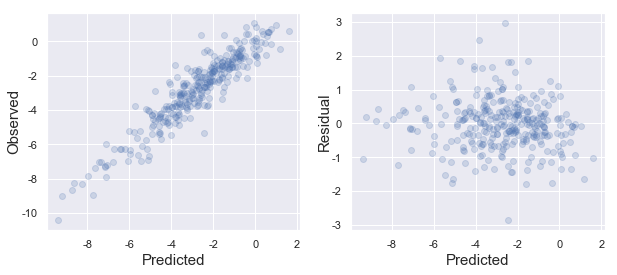

In [16]:
residuals = y_test - lin_pred_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(lin_pred_test, y_test, alpha=0.2)
ax1.set_xlabel('Predicted', fontsize=15)
ax1.set_ylabel('Observed', fontsize=15, labelpad=0)

ax2.scatter(lin_pred_test, residuals, alpha=0.2)
ax2.set_xlabel('Predicted', fontsize=15)
ax2.set_ylabel('Residual', fontsize=15, labelpad=0)

plt.show()

## Huber Regression

In [17]:
from sklearn.linear_model import HuberRegressor

def huber_pred(x_fit, y, x_target):
    HuReg = HuberRegressor()
    HuReg.fit(x_fit, np.array(y).ravel())
    return HuReg.predict(x_target)

def huber_val_rmse(x, y, cv=10):
    HuReg = HuberRegressor()
    mse = -cross_val_score(HuReg, x, np.array(y).ravel(), cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def huber_val_r2(x, y, cv=10):
    HuReg = HuberRegressor()
    r2 = cross_val_score(HuReg, x, np.array(y).ravel(), cv = cv, scoring='r2')
    return r2.mean()

In [18]:
# RMSE, R2

compare_models['RMSE_val']['Huber Reg.'] = huber_val_rmse(X_train_filtered, y_train)
compare_models['R2_val']['Huber Reg.'] = huber_val_r2(X_train_filtered, y_train)

print("RMSE:", huber_val_rmse(X_train_filtered, y_train))
print("R2:", huber_val_r2(X_train_filtered, y_train))

RMSE: 0.756437098067345
R2: 0.8586108240399094


테스트 셋에 적용

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

huber_pred_test = huber_pred(X_train_filtered, y_train, X_test_filtered)

compare_models['RMSE_test']['Huber Reg.'] = np.sqrt(mean_squared_error(y_test, huber_pred_test))
compare_models['R2_test']['Huber Reg.'] = r2_score(y_test, huber_pred_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, huber_pred_test)))
print("R2:", r2_score(y_test, huber_pred_test))

RMSE: 0.7775587766323303
R2: 0.8596040509705524


## Partial Least Squares

PLS는 상관계수가 높은 특성들이 있을 때 적용하기 좋다. 따라서 상관계수가 높은 특성들을 제거한 데이터(solTransXtrans_filtered) 대신에 모든 특성을 보유한 데이터(solTrainXtrans)를 이용할 것이다.

In [20]:
from sklearn.decomposition import PCA

pcr_rmse = []
for n_compo in range(60):
    pca = PCA(n_components= n_compo+1)
    pca_compo = pca.fit_transform(X_train)
    pcr_rmse += [lin_val_rmse(pca_compo, y_train)]
    
    
from sklearn.cross_decomposition import PLSRegression

pls_rmse = []
for n_compo in range(60):
    pls = PLSRegression(n_components= n_compo+1)
    pls.fit(X_train, y_train)
    pls_compo = pls.transform(X_train)
    pls_rmse += [lin_val_rmse(pls_compo, y_train)]

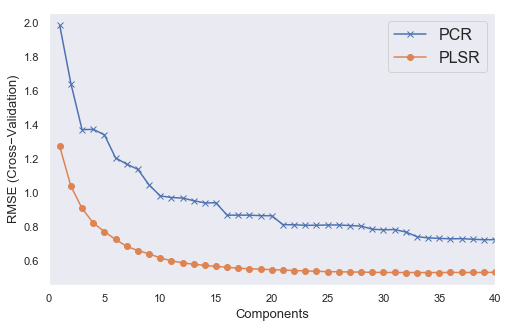

In [21]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(pcr_rmse))+1, pcr_rmse, '-x', label="PCR")
plt.plot(np.arange(len(pls_rmse))+1, pls_rmse, '-o', label="PLSR")
plt.legend(fontsize=16)
plt.xlabel("Components", fontsize=13)
plt.ylabel("RMSE (Cross−Validation)", fontsize=13)
plt.xlim(0, 40)
plt.xticks
plt.grid()
plt.show()

PLSR로 차원 축소 시, 각각의 특성이 종속 변수와 연관된 정도(상관관계)가 높다.

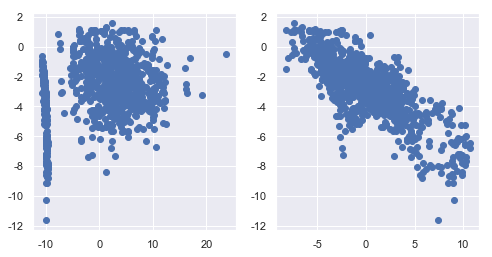

In [22]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pca = PCA(1)
plt.scatter(pca.fit_transform(X_train), y_train)

plt.subplot(1,2,2)
pls = PLSRegression(1)
pls.fit(X_train, y_train)
plt.scatter(pls.transform(X_train), y_train)

plt.show()

PCR과 PLS를 이용해 적당한 차원으로 축소시킨 후 rmse와 r2를 각각 구해보자

In [23]:
# PCR(33차원으로 축소) 때의 교차 검증
pca = PCA(33)

compare_models['RMSE_val']['PCA Reg.'] = pcr_rmse[32]
compare_models['R2_val']['PCA Reg.'] = lin_val_r2(pca.fit_transform(X_train), y_train)

print('rmse:', pcr_rmse[32])
print('R2:', lin_val_r2(pca.fit_transform(X_train), y_train))

PCAR_test = lin_pred(pca.fit_transform(X_train), y_train, pca.transform(solTestXtrans))
PCAR_residuals = y_test - PCAR_test

rmse: 0.7405195617369715
R2: 0.8654416278098234


In [24]:
LinReg = LinearRegression()

pca = PCA(33)
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)
LinReg.fit(pca_train, y_train)

compare_models['RMSE_test']['PCA Reg.'] = np.sqrt(mean_squared_error(y_test, LinReg.predict(pca_test)))
compare_models['R2_test']['PCA Reg.'] = r2_score(y_test, LinReg.predict(pca_test))

print("RMSE:", np.sqrt(mean_squared_error(y_test, LinReg.predict(pca_test))))
print("R2:", r2_score(y_test, LinReg.predict(pca_test)))

RMSE: 0.7935515161131823
R2: 0.8537693627023393


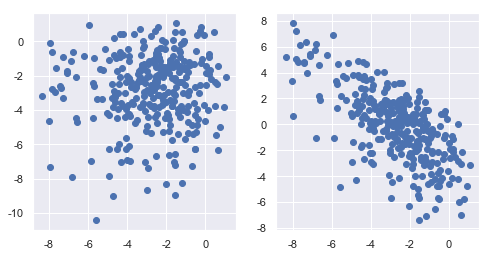

In [25]:
# PCAR 30차원으로 축소했을 때의 결과

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(PCAR_test, y_test)
plt.subplot(1,2,2)
plt.scatter(PCAR_test, PCAR_residuals)
plt.show()

In [26]:
# PLS(15차원으로 축소)의 교차검증
pls = PLSRegression(20)
pls.fit(X_train, y_train)

compare_models['RMSE_val']['PLS Reg.'] = pls_rmse[19]
compare_models['R2_val']['PLS Reg.'] = lin_val_r2(pls.transform(X_train), y_train)

print('rmse:', pls_rmse[19])
print('R2:', lin_val_r2(pls.transform(X_train), y_train))

rmse: 0.5457939684977754
R2: 0.9260410652204014


In [27]:
pls = PLSRegression(20)
pls.fit(X_train, y_train)
pls_train = pls.transform(X_train)
pls_test = pls.transform(X_test)
LinReg.fit(pls_train, y_train)

compare_models['RMSE_test']['PLS Reg.'] = np.sqrt(mean_squared_error(y_test, LinReg.predict(pls_test)))
compare_models['R2_test']['PLS Reg.'] = r2_score(y_test, LinReg.predict(pls_test))


print("RMSE:", np.sqrt(mean_squared_error(y_test, LinReg.predict(pls_test))))
print("R2:", r2_score(y_test, LinReg.predict(pls_test)))

RMSE: 0.7351942141482279
R2: 0.8744859675970951


## Ridge Regression

In [28]:
from sklearn.linear_model import Ridge

def rig_val_rmse(x, y, lam, cv=10):
    np.random.seed(42)
    RidReg = Ridge(normalize=True, alpha = lam)
    mse = -cross_val_score(RidReg, x, y, cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def rig_val_r2(x, y, lam, cv=10):
    np.random.seed(42)
    RidReg = Ridge(normalize=True, alpha = lam)
    r2 = cross_val_score(RidReg, x, y, cv = cv, scoring='r2')
    return r2.mean()


In [29]:
lambda_range = np.linspace(0.001, 0.05, 11)
ridge_rmse = []
for i in lambda_range:
    ridge_rmse.append(rig_val_rmse(X_train, y_train, i))

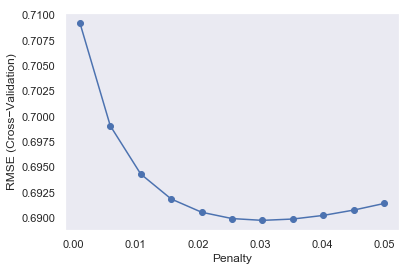

In [30]:
plt.plot(lambda_range, ridge_rmse, 'b-o')
plt.xlabel("Penalty")
plt.ylabel("RMSE (Cross−Validation)")
plt.grid()
plt.show()

In [31]:
compare_models['RMSE_val']['ridge'] = rig_val_rmse(X_train, y_train, 0.03)
compare_models['R2_val']['ridge'] = rig_val_r2(X_train, y_train, 0.03)

print("val_rmse:", rig_val_rmse(X_train, y_train, 0.03))
print("val_r2:", rig_val_r2(X_train, y_train, 0.03))

val_rmse: 0.6897485298528326
val_r2: 0.8821425546705862


테스트 셋

In [32]:
ridreg = Ridge(alpha=0.03)
ridreg.fit(X_train, y_train)
rid_pred = ridreg.predict(X_test)

compare_models['RMSE_test']['ridge'] = np.sqrt(mean_squared_error(y_test, rid_pred))
compare_models['R2_test']['ridge'] = r2_score(y_test, rid_pred)

print("RMSE:", np.sqrt(mean_squared_error(y_test, rid_pred)))
print("R2:", r2_score(y_test, rid_pred))

RMSE: 0.7460364519704634
R2: 0.8707566467816376


## Lasso regression

In [33]:
from sklearn.linear_model import Lasso

def la_val_rmse(x, y, lam, cv=10):
    np.random.seed(42)
    LasReg = Lasso(normalize=True, alpha = lam)
    mse = -cross_val_score(LasReg, x, y, cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def la_val_r2(x, y, lam, cv=10):
    np.random.seed(42)
    LasReg = Lasso(normalize=True, alpha = lam)
    r2 = cross_val_score(LasReg, x, y, cv = cv, scoring='r2')
    return r2.mean()

In [34]:
lambda_range = np.linspace(0.001, 0.05, 11) 
lasso_rmse = []
for i in lambda_range:
    lasso_rmse.append(la_val_rmse(X_train, y_train, i))

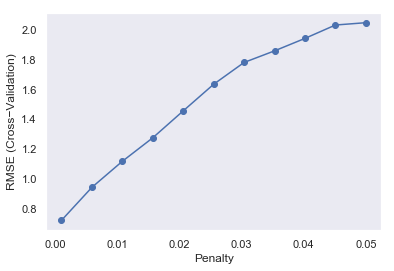

In [35]:
plt.plot(lambda_range, lasso_rmse, 'b-o')
plt.xlabel("Penalty")
plt.ylabel("RMSE (Cross−Validation)")
plt.grid()
plt.show()

선형회귀 모델들 성능 비교

In [37]:
compare_models

,RMSE_val,R2_val,RMSE_test,R2_test
Linear Reg.,0.708785,0.874305,0.742918,0.871835
Huber Reg.,0.756437,0.858611,0.777559,0.859604
PCA Reg.,0.74052,0.865716,0.793552,0.853769
PLS Reg.,0.545794,0.926041,0.735194,0.874486
ridge,0.689749,0.882143,0.746036,0.870757
Multi Layer Perceptron,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN
Tree,NaN,NaN,NaN,NaN
Bagged Tree,NaN,NaN,NaN,NaN


In [41]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

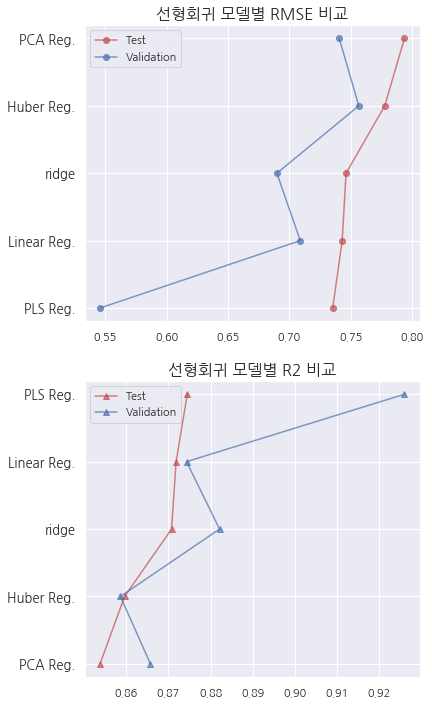

In [51]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[6,12])
plt.grid()

plt.subplot(2,1,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=13)
plt.title("선형회귀 모델별 RMSE 비교", fontsize=16)

#plot - r2

plt.subplot(2,1,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교", fontsize=16)
plt.legend()
plt.yticks(fontsize=13)
plt.show()

## MLP

In [55]:
from sklearn.neural_network import MLPRegressor

def mlp_val_rmse(x, y, learning_rate=0.01, cv=10, hidden_layer_sizes = 10, alpha = 0.0001):
    mlpr = MLPRegressor(learning_rate_init = learning_rate, 
                        hidden_layer_sizes= hidden_layer_sizes, 
                        alpha = alpha, max_iter=100)
    mse = -cross_val_score(mlpr, x, np.array(y).ravel(), cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def mlp_val_r2(x, y, learning_rate=0.01, cv=10, hidden_layer_sizes= 10, alpha = 0.0001):
    mlpr = MLPRegressor(learning_rate_init = learning_rate, 
                        hidden_layer_sizes= hidden_layer_sizes, 
                        alpha = alpha, max_iter=100)
    r2 = cross_val_score(mlpr, x, np.array(y).ravel(), cv = cv, scoring='r2')
    return r2.mean()

In [56]:
lr_range = np.linspace(0.01, 0.05, 5) 
mlp_rmse = []
for i in lr_range:
    mlp_rmse.append(mlp_val_rmse(X_train, y_train, i))

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

In [57]:
mlp_rmse # 학습률이 낮을수록 오차가 작다

[0.7420227071768067,
 0.7896550182361901,
 0.8028504364806981,
 0.7859791653494136,
 1.0229995107866214]

In [58]:
# alpha(벌점) 값에 따른 성능 비교
a, b, c = [], [], []
for i in range(1, 14):
    a += [mlp_val_rmse(X_train, y_train, hidden_layer_sizes= i, alpha=0)]
    b += [mlp_val_rmse(X_train, y_train, hidden_layer_sizes= i, alpha=0.01)]
    c += [mlp_val_rmse(X_train, y_train, hidden_layer_sizes= i, alpha=0.1)]

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

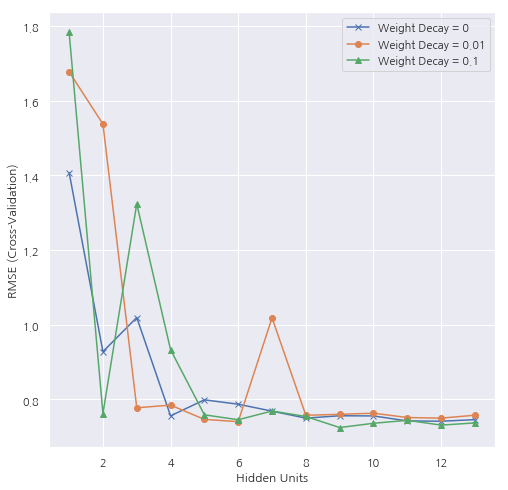

In [59]:
plt.figure(figsize=(8,8))
plt.plot(range(1,14), a, label='Weight Decay = 0', marker='x')
plt.plot(range(1,14), b, label='Weight Decay = 0.01', marker='o')
plt.plot(range(1,14), c, label='Weight Decay = 0.1', marker='^')
plt.xlabel('Hidden Units')
plt.ylabel('RMSE (Cross-Validation)')
plt.legend()
plt.show()

In [60]:
# parameter를 optimal한 값으로 설정
mlp_train_rmse = mlp_val_rmse(X_train, y_train, hidden_layer_sizes= 9, alpha=0.1)
mlp_train_r2 =  mlp_val_r2(X_train, y_train, hidden_layer_sizes= 9, alpha=0.1)

print('RMSE train: %.3f' % mlp_train_rmse)
print('R^2 train: %.3f' % mlp_train_r2)

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

RMSE train: 0.757
R^2 train: 0.861


C:\Users\renz\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [70]:
mlpr = MLPRegressor(learning_rate_init=0.005, hidden_layer_sizes= 9, alpha=0.1)
mlpr.fit(X_train, np.array(y_train).ravel())
mlp_test = mlpr.predict(X_test)

mlp_rmse = np.sqrt(mean_squared_error(mlp_test, y_test))
mlp_r2 = r2_score(mlp_test, y_test)

print('RMSE test: %.3f' % np.sqrt(mean_squared_error(mlp_test, y_test)))
print('R^2 test: %.3f' % r2_score(mlp_test, y_test))

RMSE test: 0.761
R^2 test: 0.854


In [71]:
compare_models['RMSE_val']['Multi Layer Perceptron'] = mlp_train_rmse
compare_models['R2_val']['Multi Layer Perceptron'] = mlp_train_r2

compare_models['RMSE_test']['Multi Layer Perceptron'] = mlp_rmse
compare_models['R2_test']['Multi Layer Perceptron'] = mlp_r2

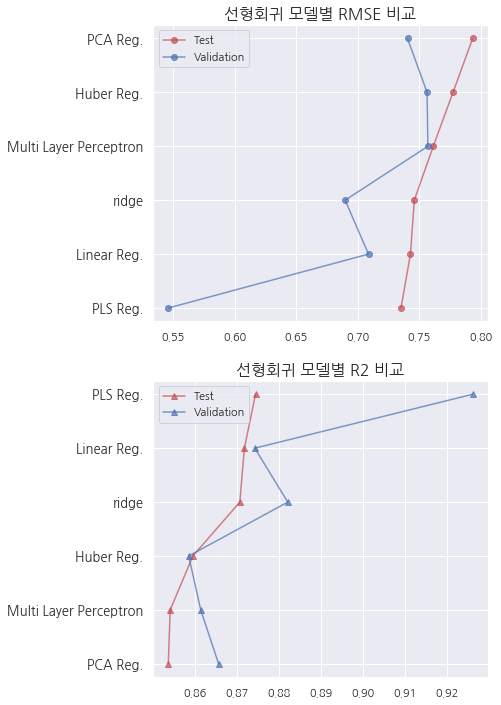

In [72]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[6,12])
plt.grid()

plt.subplot(2,1,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=13)
plt.title("선형회귀 모델별 RMSE 비교", fontsize=16)

#plot - r2

plt.subplot(2,1,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교", fontsize=16)
plt.legend()
plt.yticks(fontsize=13)
plt.show()

## SVM

In [97]:
from sklearn.svm import SVR

def svr_val_rmse(x, y, c=1, cv=10):
    svr = SVR(kernel='rbf', C=c, gamma='auto')
    mse = -cross_val_score(svr, x, np.array(y).ravel(), cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def svr_val_r2(x, y, c, cv=10):
    svr = SVR(kernel='rbf', C=c, gamma='auto')
    r2 = cross_val_score(svr, x, np.array(y).ravel(), cv = cv, scoring='r2')
    return r2.mean()

In [115]:
l_range = np.linspace(1, 30, 20) 
svr_rmse = []
for i in l_range:
    svr_rmse.append(svr_val_rmse(X_train, y_train, c=i))

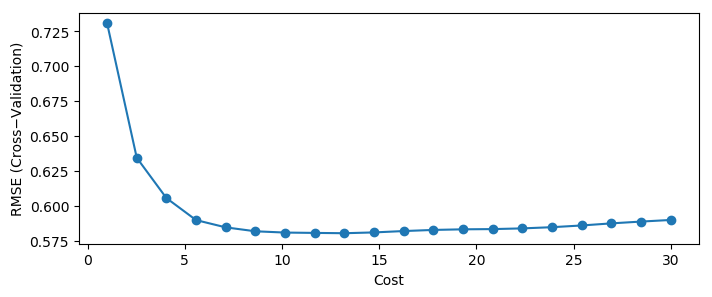

In [117]:
mpl.rcdefaults()

plt.figure(figsize=(8,3))
plt.plot(l_range, svr_rmse, marker='o')
plt.xlabel("Cost")
plt.ylabel("RMSE (Cross−Validation)")
plt.show()

In [119]:
np.argmin(svr_rmse)

8

In [120]:
l_range[8]

13.210526315789474

In [121]:
svr_rmse_pred = svr_val_rmse(X_train, y_train, c= 13)
svr_r2_pred = svr_val_r2(X_train, y_train, c= 13)

In [128]:
svr = SVR(kernel='rbf', C=13, gamma='auto')
svr.fit(X_train, np.array(y_train).ravel())

SVR(C=13, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [136]:
svr_pred = svr.predict(X_test)
svr_rmse_test = np.sqrt(mean_squared_error(svr_pred, y_test))

In [135]:
svr_r2_test = r2_score(svr_pred, y_test)

In [138]:
compare_models['RMSE_val']['SVM'] = svr_rmse_pred
compare_models['R2_val']['SVM'] = svr_r2_pred

compare_models['RMSE_test']['SVM'] = svr_rmse_test
compare_models['R2_test']['SVM'] = svr_r2_test

In [139]:
compare_models

,RMSE_val,R2_val,RMSE_test,R2_test
Linear Reg.,0.708785,0.874305,0.742918,0.871835
Huber Reg.,0.756437,0.858611,0.777559,0.859604
PCA Reg.,0.74052,0.865716,0.793552,0.853769
PLS Reg.,0.545794,0.926041,0.735194,0.874486
ridge,0.689749,0.882143,0.746036,0.870757
Multi Layer Perceptron,0.757114,0.861474,0.761498,0.854221
KNN,NaN,NaN,NaN,NaN
SVM,0.580331,0.916284,0.610065,0.905927
Tree,NaN,NaN,NaN,NaN
Bagged Tree,NaN,NaN,NaN,NaN


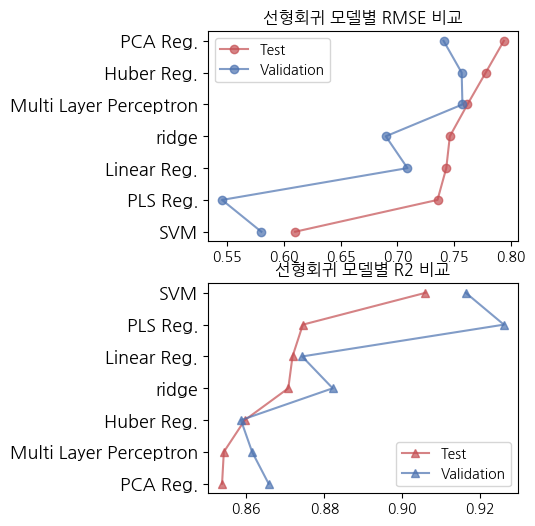

In [146]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[4,6])
plt.grid()

plt.subplot(2,1,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=13)
plt.title("선형회귀 모델별 RMSE 비교")

#plot - r2

plt.subplot(2,1,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교")
plt.legend()
plt.yticks(fontsize=13)
plt.show()

## K-Nearest Neighbors

In [147]:
from sklearn.neighbors import KNeighborsRegressor 

def knn_val_rmse(x, y, n=2, cv=10):
    knn = KNeighborsRegressor(n_neighbors=n)  
    mse = -cross_val_score(knn, x, np.array(y).ravel(), cv = cv, scoring='neg_mean_squared_error')
    return np.sqrt(mse.mean())

def knn_val_r2(x, y, n=2, cv=10):
    knn = KNeighborsRegressor(n_neighbors=n)  
    r2 = cross_val_score(knn, x, np.array(y).ravel(), cv = cv, scoring='r2')
    return r2.mean()

In [155]:
n_range = np.arange(1, 10)
knn_rmse = []
for i in n_range:
    knn_rmse.append(knn_val_rmse(X_train, y_train, n=i))

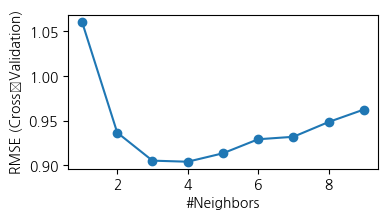

In [156]:
plt.figure(figsize=(4,2))
plt.plot(n_range, knn_rmse, marker='o')
plt.xlabel("#Neighbors")
plt.ylabel("RMSE (Cross−Validation)")
plt.show()

In [160]:
n_range[np.argmin(knn_rmse)]

4

In [161]:
knn_val_rmse_pred = knn_val_rmse(X_train, y_train, n=4)
knn_val_r2_pred = knn_val_r2(X_train, y_train, n=4)

In [162]:
knn = KNeighborsRegressor(n_neighbors=4)  
knn.fit(X_train, np.array(y_train).ravel())

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=4, p=2,
          weights='uniform')

In [164]:
knn_test_rmse = np.sqrt(mean_squared_error(knn.predict(X_test), y_test))
knn_test_r2 = r2_score(knn.predict(X_test), y_test)

In [165]:
compare_models['RMSE_val']['KNN'] = knn_val_rmse_pred
compare_models['R2_val']['KNN'] = knn_val_r2_pred

compare_models['RMSE_test']['KNN'] = knn_test_rmse
compare_models['R2_test']['KNN'] = knn_test_r2

In [170]:
knn.predict(X_train).shape

(951,)

In [186]:
nonlin_pred = knn.predict(X_test)
residuals = np.array(y_test).ravel() - nonlin_pred

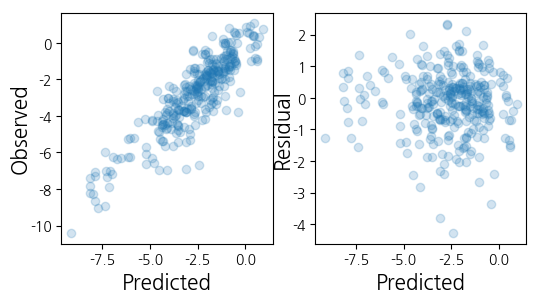

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
ax1.scatter(nonlin_pred, y_test, alpha=0.2)
ax1.set_xlabel('Predicted', fontsize=15)
ax1.set_ylabel('Observed', fontsize=15, labelpad=0)

ax2.scatter(nonlin_pred, residuals, alpha=0.2)
ax2.set_xlabel('Predicted', fontsize=15)
ax2.set_ylabel('Residual', fontsize=15, labelpad=0)

plt.show()

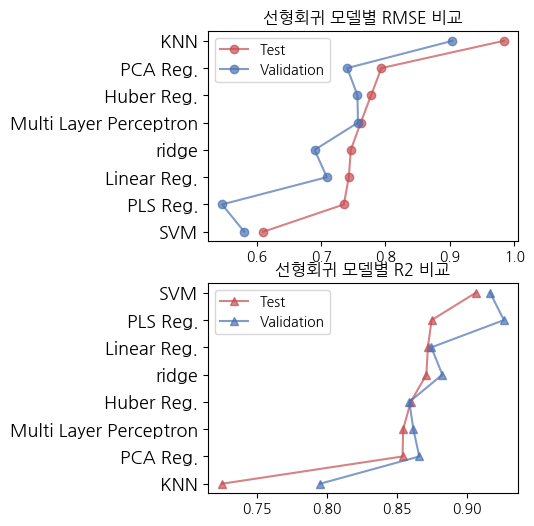

In [166]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[4,6])
plt.grid()

plt.subplot(2,1,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=13)
plt.title("선형회귀 모델별 RMSE 비교")

#plot - r2

plt.subplot(2,1,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교")
plt.legend()
plt.yticks(fontsize=13)
plt.show()

## 의사결정나무(Regression Tree)

In [192]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# cv = ShuffleSplit(['solTrainX.shape[0]', "n_splits=10", 'random_state=3'])
treg = DecisionTreeRegressor()
gs_param = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40],
              "max_leaf_nodes": [5, 20],
              }
gs_treg = GridSearchCV(treg, gs_param, cv=10, scoring="neg_mean_squared_error", n_jobs=-1)

In [193]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
gs_treg.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40], 'max_leaf_nodes': [5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

val

In [198]:
mod_pred = gs_treg.predict(X_train)

random_val_r2 = r2_score(y_train,mod_pred)
random_val_rmse = np.sqrt(mean_squared_error(y_train,mod_pred))
print(random_val_r2)
print(random_val_rmse)

0.8237894339250105
0.8586758411752341


test

In [199]:
mod_pred = gs_treg.predict(X_test)

random_test_r2 = r2_score(y_test,mod_pred)
random_test_rmse = np.sqrt(mean_squared_error(y_test,mod_pred))
print(random_test_r2)
print(random_test_rmse)

0.8287283737353315
0.8588130796707844


In [224]:
compare_models['RMSE_val']['Tree'] = random_val_rmse
compare_models['R2_val']['Tree'] = random_val_r2

compare_models['RMSE_test']['Tree'] = random_test_rmse
compare_models['R2_test']['Tree'] = random_test_r2

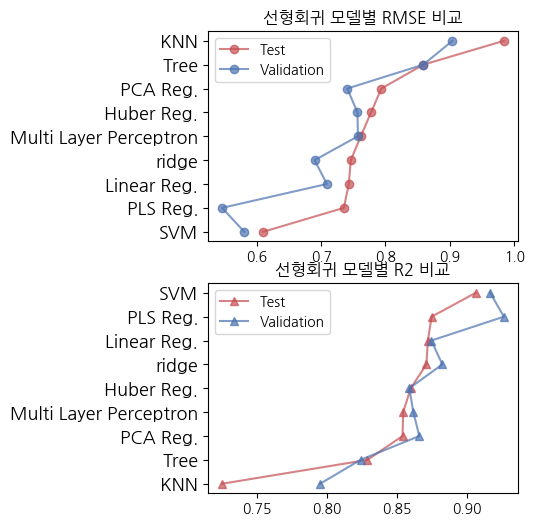

In [227]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[4,6])
plt.grid()

plt.subplot(2,1,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=13)
plt.title("선형회귀 모델별 RMSE 비교")

#plot - r2

plt.subplot(2,1,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교")
plt.legend()
plt.yticks(fontsize=13)
plt.show()

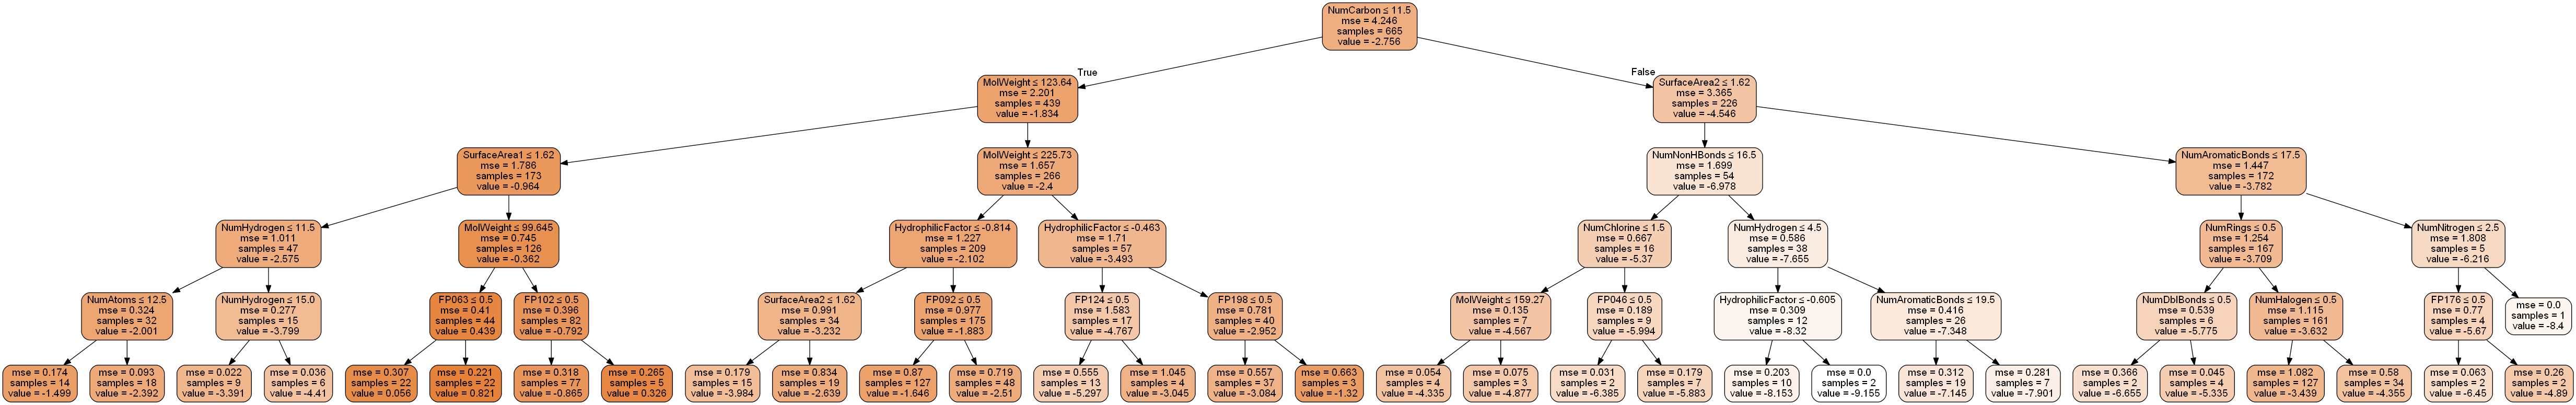

In [54]:
import graphviz
import pydotplus
from IPython.display import Image 
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image
dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, feature_names=X_train.columns,
                         class_names=y_train.columns,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Regression Tree.png')

Image(graph.create_png(),height=1000,width=1000)


Image(filename='decision tree.png', width=4000) 

## Bagging Regression

In [208]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor()
param_grid = { 'max_samples': [10,20,50],
               'max_features': [10,50,100]
                }
br_fit = GridSearchCV(br, param_grid, cv=10, scoring="neg_mean_squared_error", n_jobs=-1)
br_fit.fit(X_train, y_train)

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:397: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_samples': [10, 20, 50], 'max_features': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

교차검증

In [209]:
mod_pred = br_fit.predict(X_train)
Bagging_val_r2 = r2_score(y_train,mod_pred)
Bagging_val_rmse = np.sqrt(mean_squared_error(y_train,mod_pred))
print(Bagging_val_r2)
print(Bagging_val_rmse)

0.7857847395610091
0.9467568894818156


테스트

In [210]:
mod_pred = br_fit.predict(X_test)
Bagging_r2 = r2_score(y_test,mod_pred)
Bagging_rmse = np.sqrt(mean_squared_error(y_test,mod_pred))
print(Bagging_r2)
print(Bagging_rmse)

0.8110887902858952
0.9019548618333459


In [228]:
compare_models['RMSE_val']['Bagged Tree'] = Bagging_val_rmse
compare_models['R2_val']['Bagged Tree'] = Bagging_val_r2

compare_models['RMSE_test']['Bagged Tree'] = Bagging_rmse
compare_models['R2_test']['Bagged Tree'] = Bagging_r2

In [229]:
compare_models

,RMSE_val,R2_val,RMSE_test,R2_test
Linear Reg.,0.708785,0.874305,0.742918,0.871835
Huber Reg.,0.756437,0.858611,0.777559,0.859604
PCA Reg.,0.74052,0.865716,0.793552,0.853769
PLS Reg.,0.545794,0.926041,0.735194,0.874486
ridge,0.689749,0.882143,0.746036,0.870757
Multi Layer Perceptron,0.757114,0.861474,0.761498,0.854221
KNN,0.904153,0.794975,0.984132,0.725044
SVM,0.580331,0.916284,0.610065,0.905927
Tree,0.858676,0.823789,0.858813,0.828728
Bagged Tree,0.946757,0.785785,0.901955,0.811089


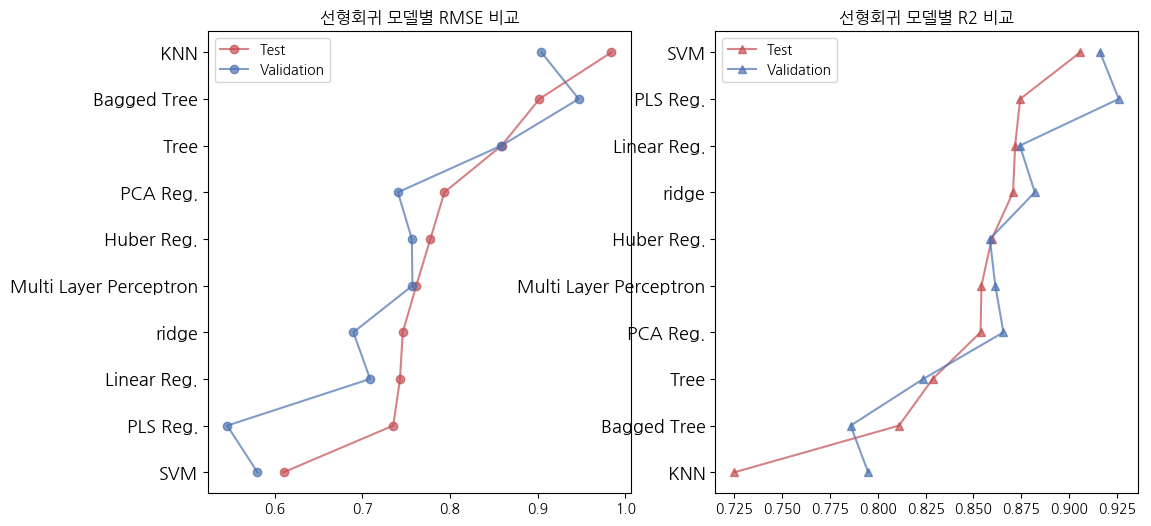

In [230]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[12,6])
plt.grid()

plt.subplot(1,2,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=13)
plt.title("선형회귀 모델별 RMSE 비교")

#plot - r2

plt.subplot(1,2,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교")
plt.legend()
plt.yticks(fontsize=13)
plt.show()

## Random Forest Regression

In [216]:
from sklearn.ensemble import RandomForestRegressor

In [217]:
rfr=RandomForestRegressor()
param_grid = { 
    'n_estimators': [30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5],
    'criterion' :['mse', 'mae']
}
rfr_fit = GridSearchCV(rfr, param_grid, cv=10, scoring="neg_mean_squared_error", n_jobs=-1)
rfr_fit.fit(X_train, y_train)

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [30, 50], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5], 'criterion': ['mse', 'mae']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [231]:
mod_pred = rfr_fit.predict(X_train)
rf_val_r2 = r2_score(y_train,mod_pred)
rf_val_rmse = np.sqrt(mean_squared_error(y_train,mod_pred))
print(rf_val_r2)
print(rf_val_rmse)

0.8931847024244834
0.66854400446742


In [232]:
mod_pred = rfr_fit.predict(X_test)
rf_r2 = r2_score(y_test,mod_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test,mod_pred))
print(rf_r2)
print(rf_rmse)

0.8714435998714682
0.7440511473217502


In [233]:
compare_models['RMSE_val']['Random Forest'] = rf_val_rmse
compare_models['R2_val']['Random Forest'] = rf_val_r2

compare_models['RMSE_test']['Random Forest'] = rf_rmse
compare_models['R2_test']['Random Forest'] = rf_r2

In [234]:
compare_models

,RMSE_val,R2_val,RMSE_test,R2_test
Linear Reg.,0.708785,0.874305,0.742918,0.871835
Huber Reg.,0.756437,0.858611,0.777559,0.859604
PCA Reg.,0.74052,0.865716,0.793552,0.853769
PLS Reg.,0.545794,0.926041,0.735194,0.874486
ridge,0.689749,0.882143,0.746036,0.870757
Multi Layer Perceptron,0.757114,0.861474,0.761498,0.854221
KNN,0.904153,0.794975,0.984132,0.725044
SVM,0.580331,0.916284,0.610065,0.905927
Tree,0.858676,0.823789,0.858813,0.828728
Bagged Tree,0.946757,0.785785,0.901955,0.811089


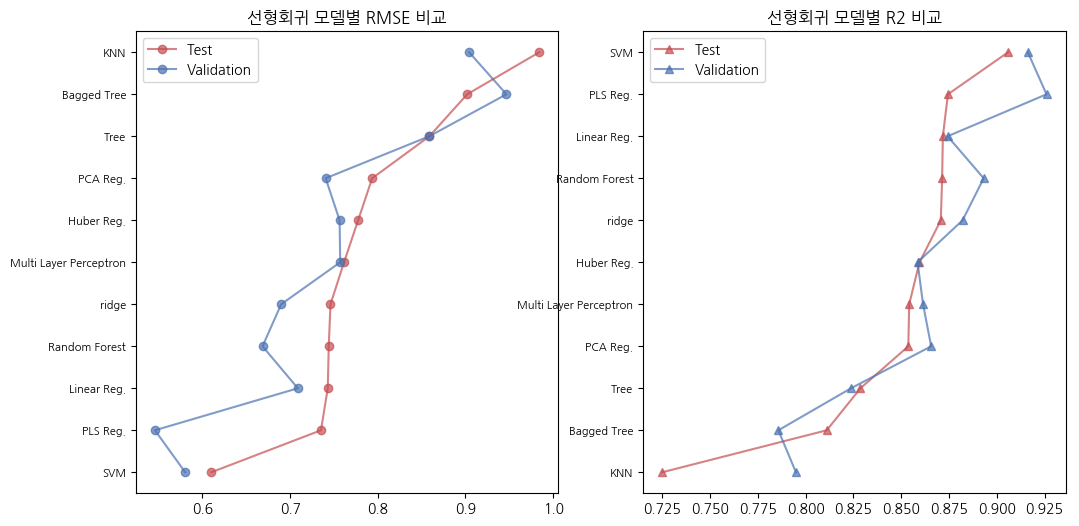

In [235]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[12,6])
plt.grid()

plt.subplot(1,2,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=8)
plt.title("선형회귀 모델별 RMSE 비교")

#plot - r2

plt.subplot(1,2,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교")
plt.legend()
plt.yticks(fontsize=8)
plt.show()

## GBM

In [236]:
from sklearn.ensemble import GradientBoostingRegressor
gs_param = {
    'learning_rate': [0.01, 0.1],
     "max_depth": [2, 6, 8],
    'n_estimators': [30, 50],
    'subsample': [0.5],
}

gbr = GradientBoostingRegressor()
gs_gbr = GridSearchCV(gbr, gs_param, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gs_gbr.fit(X_train, y_train)

C:\Users\renz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\renz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 6, 8], 'n_estimators': [30, 50], 'subsample': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [237]:
mod_pred = gs_gbr.predict(X_train)
GBM_val_r2 = r2_score(y_train,mod_pred)
GBM_val_rmse = np.sqrt(mean_squared_error(y_train,mod_pred))
print(GBM_val_r2)
print(GBM_val_rmse)

0.9912975114750545
0.1908248811979423


In [238]:
mod_pred = gs_gbr.predict(X_test)
GBM_test_r2 = r2_score(y_test,mod_pred)
GBM_test_rmse = np.sqrt(mean_squared_error(y_test,mod_pred))
print(GBM_test_r2)
print(GBM_test_rmse)

0.9052090597966891
0.638909513354041


In [240]:
compare_models['RMSE_val']['GBM'] = GBM_val_rmse
compare_models['R2_val']['GBM'] = GBM_val_r2

compare_models['RMSE_test']['GBM'] = GBM_test_rmse
compare_models['R2_test']['GBM'] = GBM_test_r2

In [241]:
compare_models

,RMSE_val,R2_val,RMSE_test,R2_test
Linear Reg.,0.708785,0.874305,0.742918,0.871835
Huber Reg.,0.756437,0.858611,0.777559,0.859604
PCA Reg.,0.74052,0.865716,0.793552,0.853769
PLS Reg.,0.545794,0.926041,0.735194,0.874486
ridge,0.689749,0.882143,0.746036,0.870757
Multi Layer Perceptron,0.757114,0.861474,0.761498,0.854221
KNN,0.904153,0.794975,0.984132,0.725044
SVM,0.580331,0.916284,0.610065,0.905927
Tree,0.858676,0.823789,0.858813,0.828728
Bagged Tree,0.946757,0.785785,0.901955,0.811089


## 모델 별 성능 평가

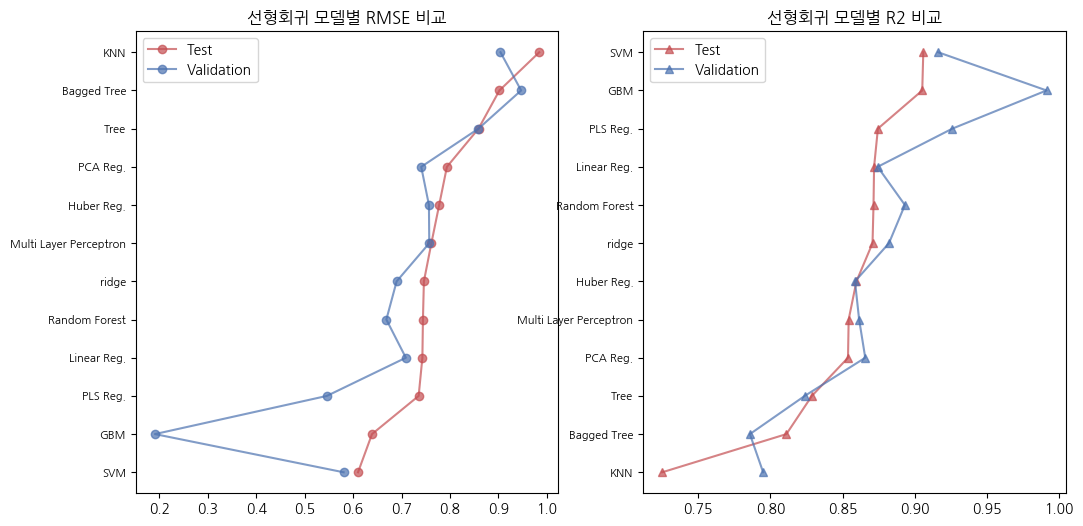

In [245]:
compare_models_RMSE = compare_models.sort_values(by='RMSE_test')
compare_models_R2 = compare_models.sort_values(by='R2_test')
compare_models_RMSE.dropna(inplace=True)
compare_models_R2.dropna(inplace=True)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=[12,6])
plt.grid()

plt.subplot(1,2,1)
plt.plot(compare_models_RMSE['RMSE_test'], compare_models_RMSE.index, alpha=0.7, color='r', marker='o', label='Test')
plt.plot(compare_models_RMSE['RMSE_val'], compare_models_RMSE.index, alpha=0.7, color='b', marker='o', label='Validation')
plt.legend()
plt.yticks(fontsize=8)
plt.title("선형회귀 모델별 RMSE 비교")

#plot - r2

plt.subplot(1,2,2)
plt.plot(compare_models_R2['R2_test'], compare_models_R2.index, alpha=0.7, color='r', marker='^', label='Test')
plt.plot(compare_models_R2['R2_val'], compare_models_R2.index, alpha=0.7, color='b', marker='^', label='Validation')
plt.title("선형회귀 모델별 R2 비교")
plt.legend()
plt.yticks(fontsize=8)
plt.show()

결론: 분석한 데이터는 1200여개의 화합물 데이터로서, 200개가 넘는 특징들을 통해서 용해도를 예측하는 것이 목적이었습니다. 연속형 변수의 경우 비대칭도(skewness)를 조정하여 성능을 높일 수 있었습니다. RMSE와 R2를 기준으로 12개의 모델을 평가한 결과, 현재 데이터 상에서는 SVM이 가장 좋은 성적을 거둔 것으로 나타났습니다. 눈에 띄는 것은 GBM 모델이었는데, 검증셋과 테스트셋의 예측 결과 간의 차이가 가장 컸습니다. 이는 GBM이 과적합되었다는 것을 의미하는데, 선형회귀 모델처럼 단순한 모델과는 달리 사용할 때 좀 더 주의를 요한다는 사실을 알 수 있습니다. PCR과 PLSR은 둘 다 부분선형회귀에 속하지만, 화합물의 용해도를 예측하는 데에는 PLSR이 다른 복잡한 모델들에 비해서도 뒤지지 않는다는 사실도 알 수 있었습니다. 